In [1]:
%matplotlib inline

import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, num2date
import os
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
import sys
import xgboost as xgb

notebook_path = !pwd

prj_path = os.path.abspath(os.path.join(notebook_path[0], '../', ''))

model_pkg_path = os.path.join(prj_path, 'rappi-app')

sys.path.append(model_pkg_path)

print('Added to path: %s' % model_pkg_path)

from eval_utils import classification_report

from app_utils import transformer
from app_utils import encoder
from app_utils import scorer

Added to path: /Users/lsanchez/ML-service/rappi-app


# Read data.

In [2]:
DATA_PATH = os.path.join('orders.csv')
print(DATA_PATH)

original_data = pd.read_csv(
    DATA_PATH,
    dtype={'order_id': str, 'store_id': str},
    parse_dates=['created_at'])

original_data.head()

orders.csv


,order_id,store_id,to_user_distance,to_user_elevation,total_earning,created_at,taken
0,14364873,30000009,2.478101,-72.719360,4200,2017-09-07 20:02:17+00:00,0
1,14370123,30000058,0.451711,37.754761,4200,2017-09-07 20:13:16+00:00,0
2,14368534,900003684,2.026072,207.191162,4000,2017-09-07 20:07:23+00:00,0
3,14370258,900014452,2.671432,1.722656,4400,2017-09-07 20:15:19+00:00,1
4,14369923,900014085,0.965496,117.429199,3450,2017-09-07 20:12:14+00:00,1


In [3]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146987 entries, 0 to 146986
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   order_id           146987 non-null  object             
 1   store_id           146987 non-null  object             
 2   to_user_distance   146987 non-null  float64            
 3   to_user_elevation  146987 non-null  float64            
 4   total_earning      146987 non-null  int64              
 5   created_at         146987 non-null  datetime64[ns, UTC]
 6   taken              146987 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(2), int64(2), object(2)
memory usage: 7.9+ MB


# Data Analysis.

Text(0.5, 1.0, 'Target mean')

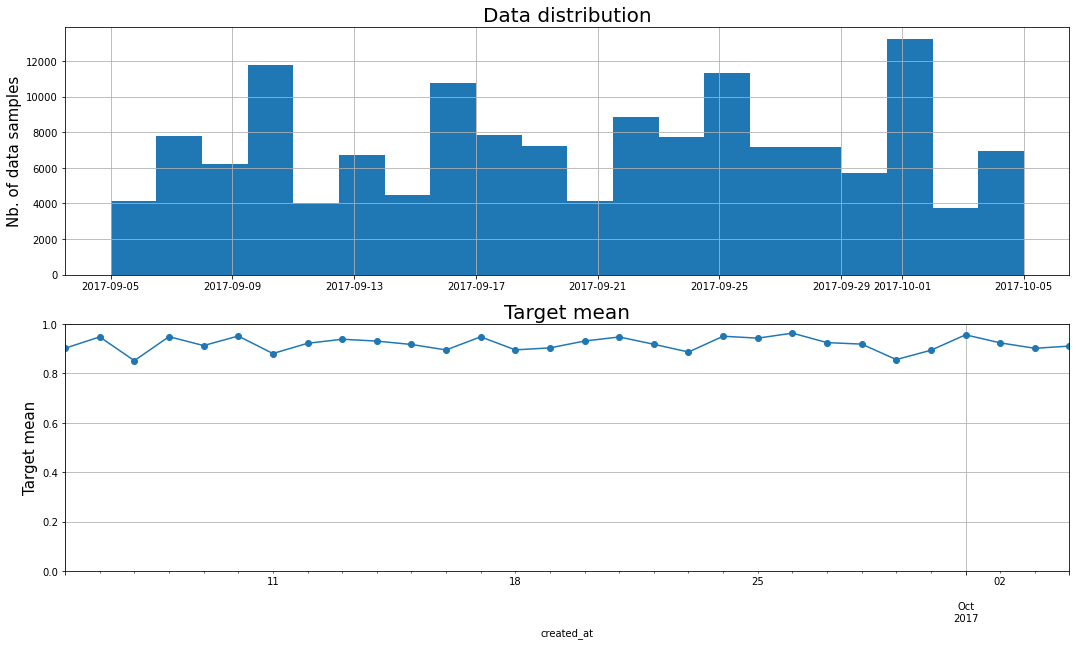

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(18, 10))
original_data['created_at'].hist(bins=20, ax=ax[0])
ax[0].set_title('Data distribution', fontsize=20)
ax[0].set_ylabel('Nb. of data samples', fontsize=15)

original_data.set_index(
    'created_at'
).groupby(
    pd.Grouper(freq='D')
).apply(
    lambda x: x['taken'].mean()).plot(
    marker='o', 
    ax=ax[1],
    grid=True,
    ylim=(0, 1))
ax[1].set_ylabel('Target mean', fontsize=15)
ax[1].set_title('Target mean', fontsize=20)

# Experiment.

The experiment consists of multiple evaluations rounds. In each evaluation round, 4 data partitions are created:

- Oldest 30% of data, used to get target statistics.
- Train data, the data used to fit the model
- Out-of-sample data (30% of train). This partition shares the time lapse of the train, used to trigger the early-stopping rounds feature during the model training.
- Out-of-time data, used to asses model performance.


In [5]:
CATEG_ENC_SIZE = .3
OOS_SIZE = .3

data = transformer.make_features(original_data)

2020-11-08 18:40:29,716 :: INFO :: make_features :: 77 :: Set data types
2020-11-08 18:40:29,717 :: INFO :: make_features :: 79 :: order_id: str
2020-11-08 18:40:29,739 :: INFO :: make_features :: 79 :: store_id: str
2020-11-08 18:40:29,757 :: INFO :: make_features :: 79 :: to_user_distance: float
2020-11-08 18:40:29,758 :: INFO :: make_features :: 79 :: to_user_elevation: float
2020-11-08 18:40:29,759 :: INFO :: make_features :: 79 :: total_earning: float
2020-11-08 18:40:29,761 :: INFO :: make_features :: 79 :: created_at: date
2020-11-08 18:40:29,770 :: INFO :: make_features :: 87 :: Creating features


             precision    recall  f1-score  support     pred      AUC
0             0.173384  0.369630  0.236045   1350.0   2878.0  0.66813
1             0.931216  0.828849  0.877055  13900.0  12372.0  0.66813
avg / total   0.864129  0.788197  0.820310  15250.0  15250.0  0.66813


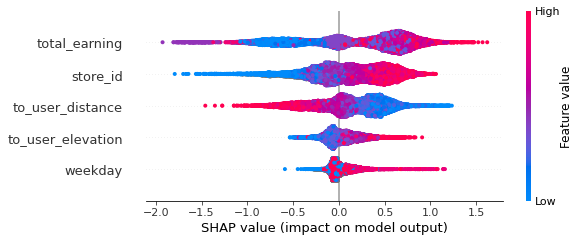

             precision    recall  f1-score  support     pred       AUC
0             0.199811  0.368375  0.259090   1151.0   2122.0  0.709757
1             0.943818  0.877938  0.909687  13911.0  12940.0  0.709757
avg / total   0.886963  0.838999  0.859970  15062.0  15062.0  0.709757


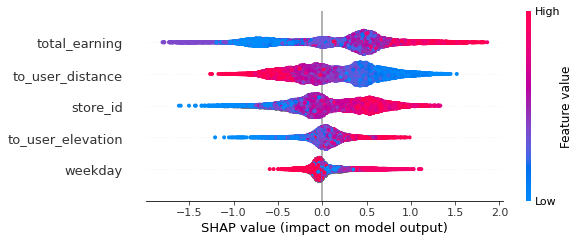

             precision    recall  f1-score  support     pred       AUC
0             0.131502  0.599114  0.215667    903.0   4114.0  0.715807
1             0.959280  0.704735  0.812539  12101.0   8890.0  0.715807
avg / total   0.901799  0.697401  0.771092  13004.0  13004.0  0.715807


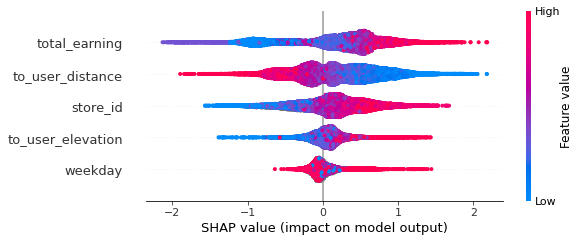

             precision    recall  f1-score  support     pred       AUC
0             0.136875  0.404240  0.204505   1415.0   4179.0  0.662023
1             0.943461  0.795915  0.863430  17674.0  14910.0  0.662023
avg / total   0.883671  0.766881  0.814586  19089.0  19089.0  0.662023


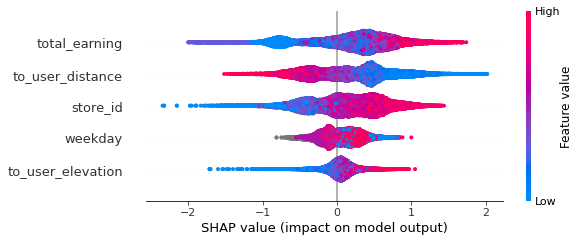

             precision    recall  f1-score  support     pred       AUC
0             0.085617  0.593861  0.149658    847.0   5875.0  0.636277
1             0.959343  0.601750  0.739590  13489.0   8461.0  0.636277
avg / total   0.907721  0.601283  0.704736  14336.0  14336.0  0.636277


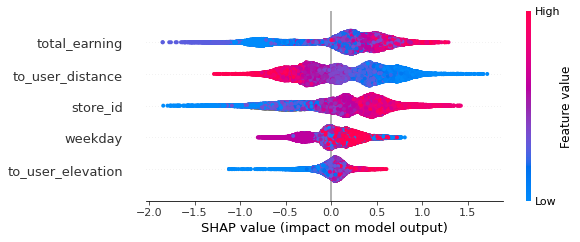

             precision    recall  f1-score  support     pred       AUC
0             0.153799  0.584491  0.243520   1728.0   6567.0  0.673066
1             0.941905  0.676881  0.787698  17198.0  12359.0  0.673066
avg / total   0.869948  0.668446  0.738013  18926.0  18926.0  0.673066


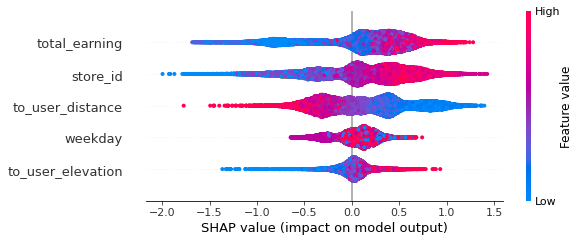

             precision    recall  f1-score  support     pred       AUC
0             0.146630  0.565217  0.232853    943.0   3635.0  0.672842
1             0.941918  0.681879  0.791077   9751.0   7059.0  0.672842
avg / total   0.871789  0.671592  0.741852  10694.0  10694.0  0.672842


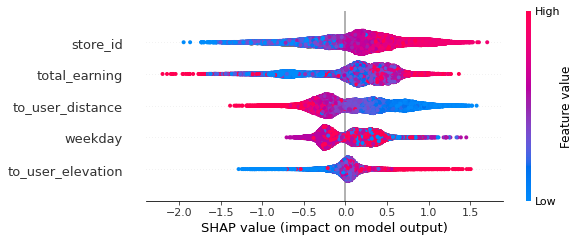

In [6]:
results, dates, feature_importance = [], [], []
for it, (oot_date, oot) in enumerate(data.set_index('created_at').groupby(pd.Grouper(freq='3D'))):    
    # The out-of-time partition
    oot.reset_index(inplace=True)
    
    # Get train data
    train = data[
        data['created_at'] < oot['created_at'].min()
    ].sort_values(
        'created_at')
    
    # Ensure that train data spans in at least one full week
    if train['weekday'].nunique() < 7:
        continue

    # Store evaluation dates
    dates.append(oot_date)
    
    # Get the data used for target mean encoder
    # Get first CATEG_ENC_SIZE
    idx_categ_split = int(train.shape[0] * CATEG_ENC_SIZE)
    categ_data = train.iloc[:idx_categ_split]
    train = train.iloc[idx_categ_split:]
    
    # Get target mean encoder for categorical features
    categ_enc = transformer.get_encoder(categ_data)
    
    # Get X and y
    y = train['taken']
    X = transformer.encode(train, categ_enc)
    
    # Split train and out-of-sample partitions
    X_train, X_oos, y_train, y_oos = train_test_split(
        X, y, test_size=OOS_SIZE, random_state=42)
    
    # Train model
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    xgb_model = xgb.XGBClassifier(n_estimators=1000, scale_pos_weight=scale_pos_weight,)
    
    xgb_model.fit(
        X_train, 
        y_train, 
        early_stopping_rounds=10, 
        eval_set=[(X_oos, y_oos)],
        eval_metric=['logloss', 'auc'],
        verbose=False)
    
    # After fitting the model, allow to re-compute target means up to the out-of-time.
    categ_enc = transformer.get_encoder(
        pd.concat([train, categ_data], axis=0))
    y_oot = oot['taken'].values
    X_oot = transformer.encode(oot, categ_enc)
    
    # Make inference on out-of-time data
    oot_y_score = xgb_model.predict_proba(X_oot)
    oot_y_pred = (oot_y_score[:, 1] > .5).astype(int)
    
    # Get classification report
    classification_report_df = classification_report(
        y_true=y_oot, 
        y_score=oot_y_score, 
        y_pred=oot_y_pred)

    # Store the evaluation metrics
    results.append(classification_report_df)
    print(classification_report_df)
    
    # Get feature importance
    explainer = shap.TreeExplainer(xgb_model)
    
    shaps_values = pd.DataFrame(
        explainer.shap_values(X_train),
        columns=X_train.columns)
    
    shap.summary_plot(
        shaps_values.values, 
        X_train,
        max_display=1000)

    # Store feature importance
    feature_importance.append(shaps_values.abs().sum(axis=0).sort_values())
    
feature_importance = pd.DataFrame(
    feature_importance,
    index=dates)

# Save artifacts

In [7]:
# Save last model and last categorical encoder objects
encoder.save(categ_enc)
scorer.save(xgb_model)

# Evaluation

FixedFormatter should only be used together with FixedLocator


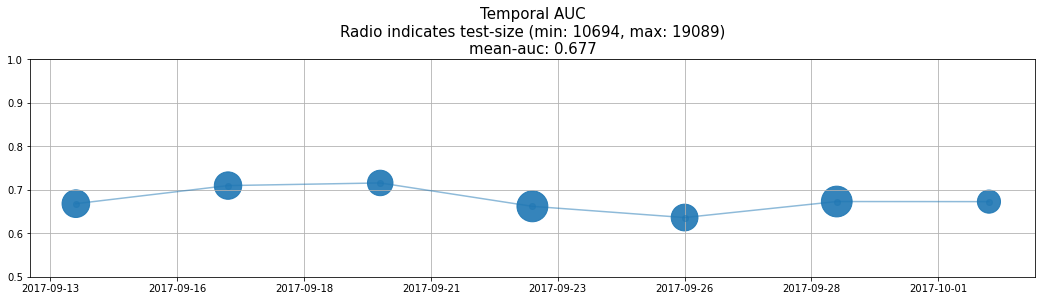

In [8]:
dates_ = [date2num(x) for x in dates]

auc = pd.Series(
    [x.loc['avg / total']['AUC'] for x in results], 
    index=dates_)
auc.name = 'AUC'

support = pd.Series(
    [x.loc['avg / total']['support'] for x in results], 
    index=dates_)

fig, ax = plt.subplots(1, 1, figsize=(18, 4))
auc.plot(
    marker='o',
    grid=True,
    ax=ax,
    alpha=.5)

ax.scatter(
    x=dates_, 
    y=auc,
    s=(support * .05).values,
    alpha=.9)

ax.set_ylim(.5, 1.)
ax.set_title(
    (
        'Temporal AUC\n'
        'Radio indicates test-size (min: %s, max: %s)\n'
        'mean-auc: %s'
    ) % (
        int(support.min()), 
        int(support.max()),
        round(auc.mean(), 3)
    ),
    fontsize=15)

ax.set_xticklabels([
    str(num2date(x) ).split(' ')[0]
    for x in ax.get_xticks()]);

# Get drifts in feature importance

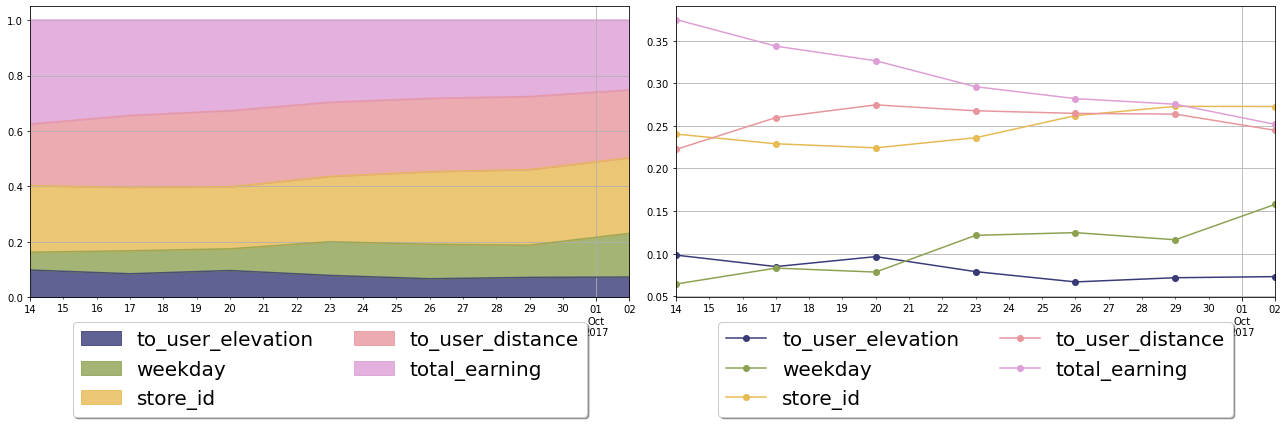

In [9]:
data_plot = feature_importance[feature_importance.sum().sort_values().iloc[-20:].index]
data_plot = (data_plot.T / data_plot.sum(axis=1)).T

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
data_plot.plot(
    kind='area',
    stacked=True,
    ax=ax[0],
    grid=True,
    alpha=.8,
    cmap='tab20b')

data_plot.plot(
    marker='o', 
    ax=ax[1],
    cmap='tab20b',
    legend=False,
    grid=True)

ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5));

fig.set_tight_layout('tight')
for x in ax:
    x.legend(
        loc='upper center', 
        bbox_to_anchor=(0.5, -0.05), 
        fancybox=True, 
        shadow=True, 
        ncol=2, 
        fontsize=20)

# Change in total-earning

# Consistency test